In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from random import sample 
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
import seaborn as sns
sns.set(style="darkgrid")

from skimage import io
##Import any other packages you may need here

import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

import seaborn as sns
sns.set(style="darkgrid")

from keras.preprocessing.image import ImageDataGenerator

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [9]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
943,00004904_013.png,Consolidation|Effusion|Mass,13,4904,053Y,F,AP,2500,2048,0.171,0.171
3691,00018117_001.png,Emphysema|Pneumothorax,1,18117,034Y,M,AP,2500,2048,0.168,0.168
4294,00021188_012.png,Atelectasis,12,21188,066Y,F,PA,2544,3056,0.139,0.139


In [10]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2942,00014452_008.png,Atelectasis|Pleural_Thickening,8,14452,067Y,M,AP,2500,2048,0.168,0.168,/data/images_007/images/00014452_008.png
2553,00012834_148.png,Infiltration,148,12834,034Y,M,AP,2500,2048,0.168,0.168,/data/images_006/images/00012834_148.png
2396,00012087_042.png,Fibrosis|Infiltration,42,12087,068Y,F,PA,2516,3056,0.139,0.139,/data/images_006/images/00012087_042.png


In [11]:
all_xray_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [12]:
df_xray_clean = all_xray_df.drop('Unnamed: 11', axis=1)


In [13]:
df_xray_clean.describe()


,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


In [14]:
df_xray_clean = df_xray_clean[df_xray_clean['Patient Age'] <= 100]


In [15]:
all_labels = np.unique(list(chain(*df_xray_clean['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [16]:
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df_xray_clean[c_label] = df_xray_clean['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df_xray_clean.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
102027,00027156_001.png,No Finding,1,27156,37,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
106334,00028635_000.png,No Finding,0,28635,41,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
84302,00020725_000.png,No Finding,0,20725,50,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


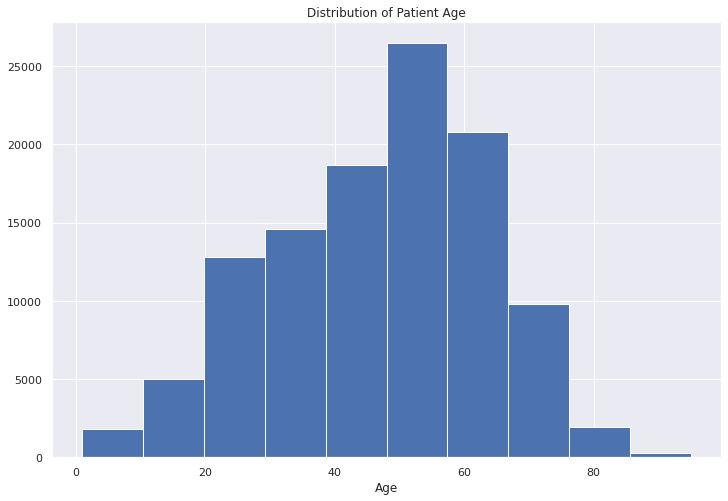

In [17]:
plt.hist(df_xray_clean['Patient Age']);
plt.title('Distribution of Patient Age');
plt.xlabel('Age');

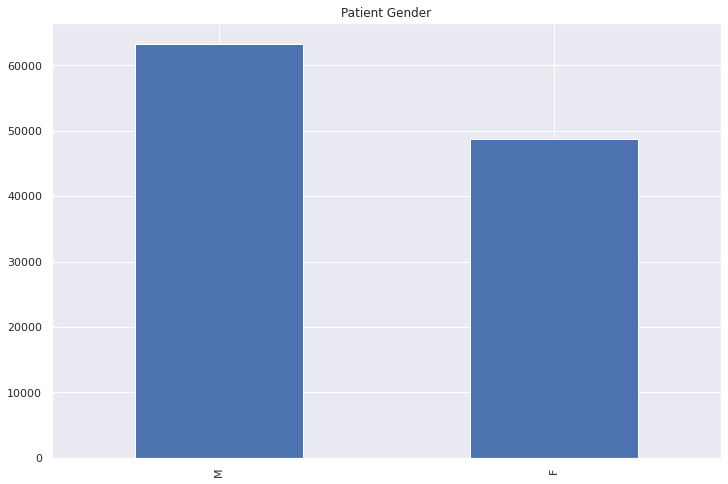

In [18]:
df_xray_clean['Patient Gender'].value_counts().plot(kind="bar");
plt.title('Patient Gender');

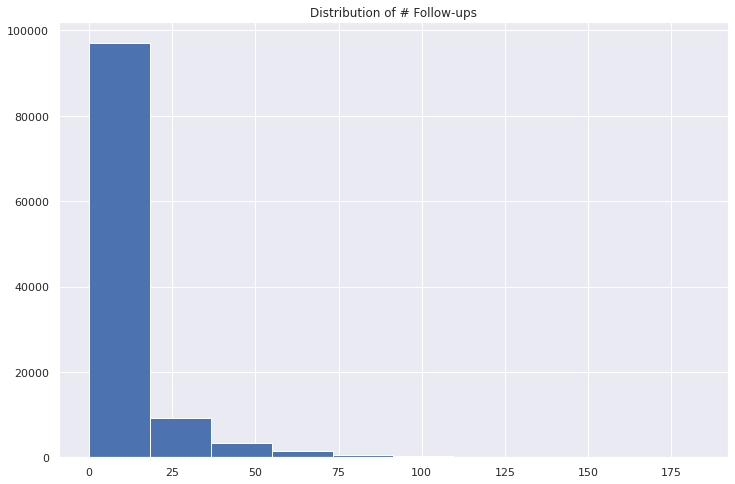

In [19]:
plt.hist(df_xray_clean['Follow-up #']);
plt.title('Distribution of # Follow-ups');

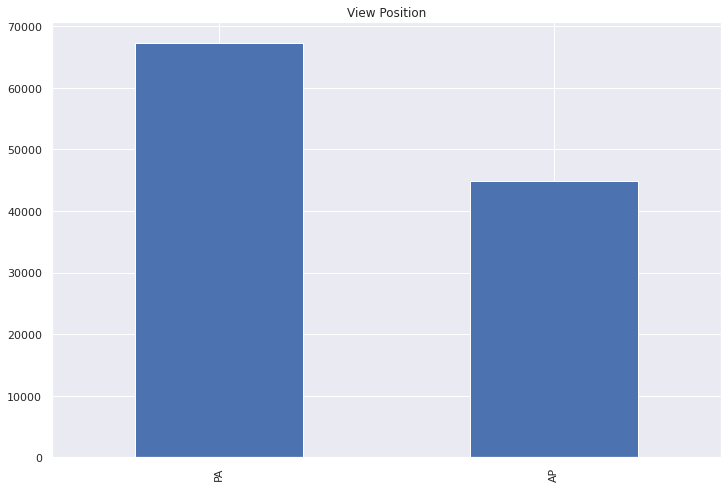

In [20]:
df_xray_clean['View Position'].value_counts().plot(kind="bar");
plt.title('View Position');

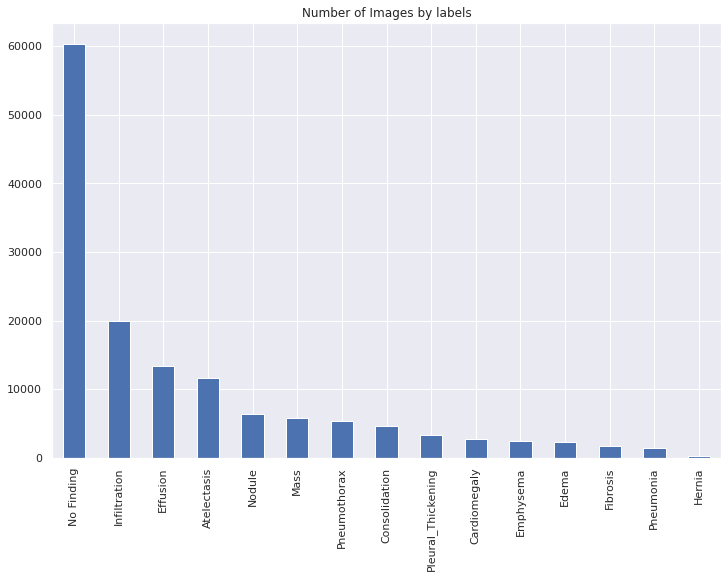

In [21]:
ax = df_xray_clean[all_labels].sum().sort_values(ascending=False).plot(kind='bar');
ax.set(title = 'Number of Images by labels');

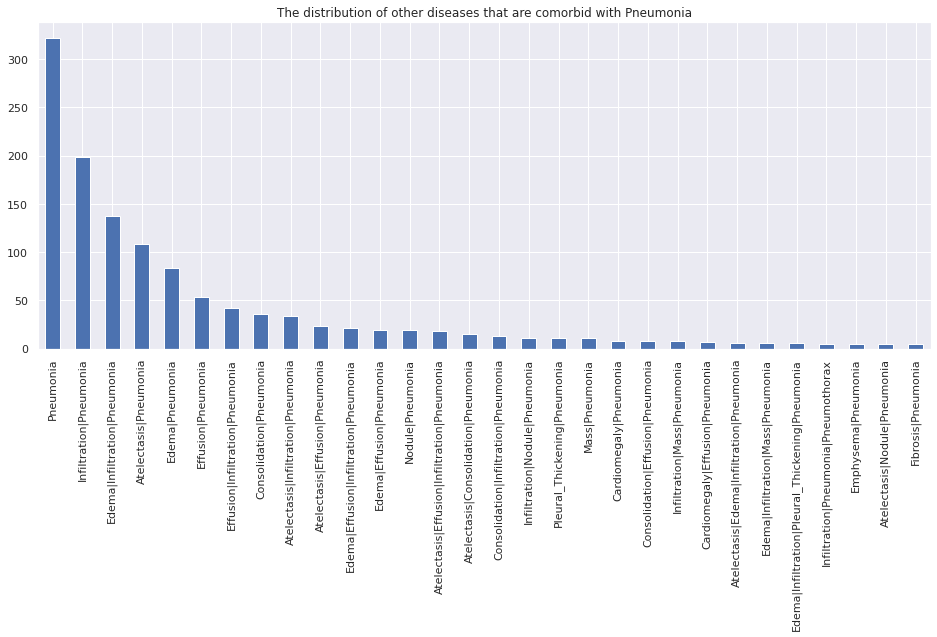

In [22]:
plt.figure(figsize=(16,6))
df_xray_clean[df_xray_clean.Pneumonia==1]['Finding Labels'].value_counts()[:30].plot(kind='bar');
plt.title('The distribution of other diseases that are comorbid with Pneumonia');


In [23]:
df_xray_clean['Num_Diseases'] = df_xray_clean[all_labels].sum(axis=1)


In [24]:
df_xray_clean['Num_Diseases'].describe()


count    112104.000000
mean          1.262372
std           0.629874
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: Num_Diseases, dtype: float64

In [25]:
num_rows = sample_df.shape[0]

In [26]:
num_rows

5606

In [27]:
df_xray_no_finding = df_xray_clean[df_xray_clean['No Finding'] == 1]


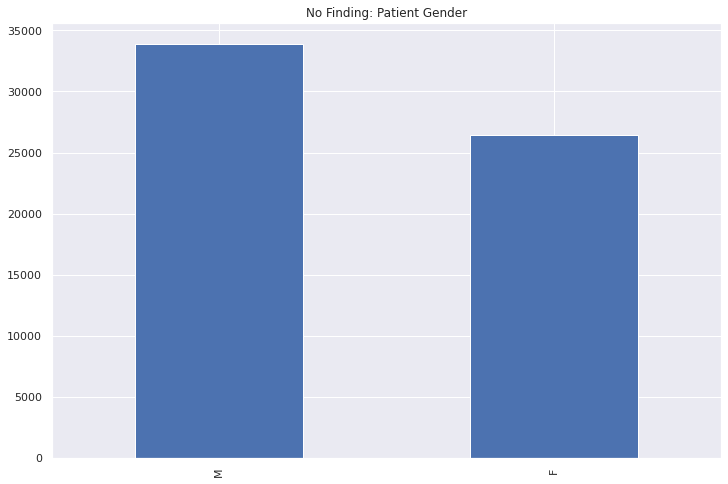

In [28]:
df_xray_no_finding['Patient Gender'].value_counts().plot(kind="bar");
plt.title('No Finding: Patient Gender');

In [29]:
# Number of Pneumonia
numPneumonia = int(df_xray_clean['Pneumonia'].sum())
ratePneumonia = 100*df_xray_clean['Pneumonia'].mean()
print('Number of Pneumonia cases: {} ({:.4f}%)'.format(numPneumonia, ratePneumonia))
print('Number of non-Pneumonia cases: {} ({:.4f}%)'.format(df_xray_clean.shape[0] - numPneumonia, 100 - ratePneumonia))

Number of Pneumonia cases: 1430 (1.2756%)
Number of non-Pneumonia cases: 110674 (98.7244%)


In [ ]:
def get_unique_labels(col):
    labels = set()
    for l in col.unique():
        labels.update(l.split('|'))
    print('Total unique labels: {}'.format(len(labels)))
    return labels

In [ ]:
def split_labels_cols(labels, df):
    for l in labels:
        df[l] = df['Finding Labels'].map(lambda x: 1.0 if l in x else 0)

In [104]:
labels = get_unique_labels(df_xray_clean['Finding Labels'])


In [37]:
# get entries that have only pneumonia as a disease
sample_df['sum_diseases'] = sample_df.iloc[:,11:].sum(axis=1)

In [38]:
 img_paths = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['img_path'] = sample_df['Image Index'].map(img_paths.get)

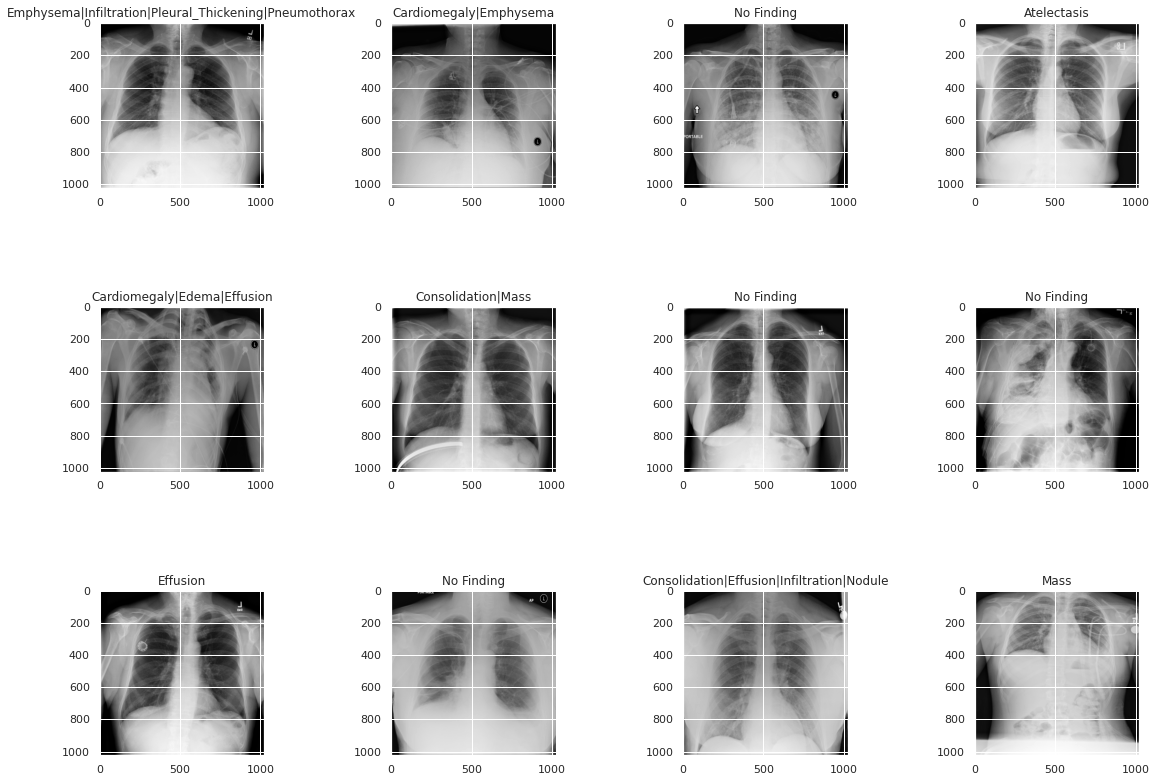

In [40]:

rows=3
cols=4

fig, m_axs = plt.subplots(rows,cols, figsize = (16, 12))
m_axs = m_axs.flatten()
imgs = sample_df.sample(rows*cols).img_path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(sample_df.iloc[ind]['Finding Labels'])
    ind=ind+1
    
plt.tight_layout()

In [41]:
sample_df_pneu = sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["sum_diseases"] == 1)]


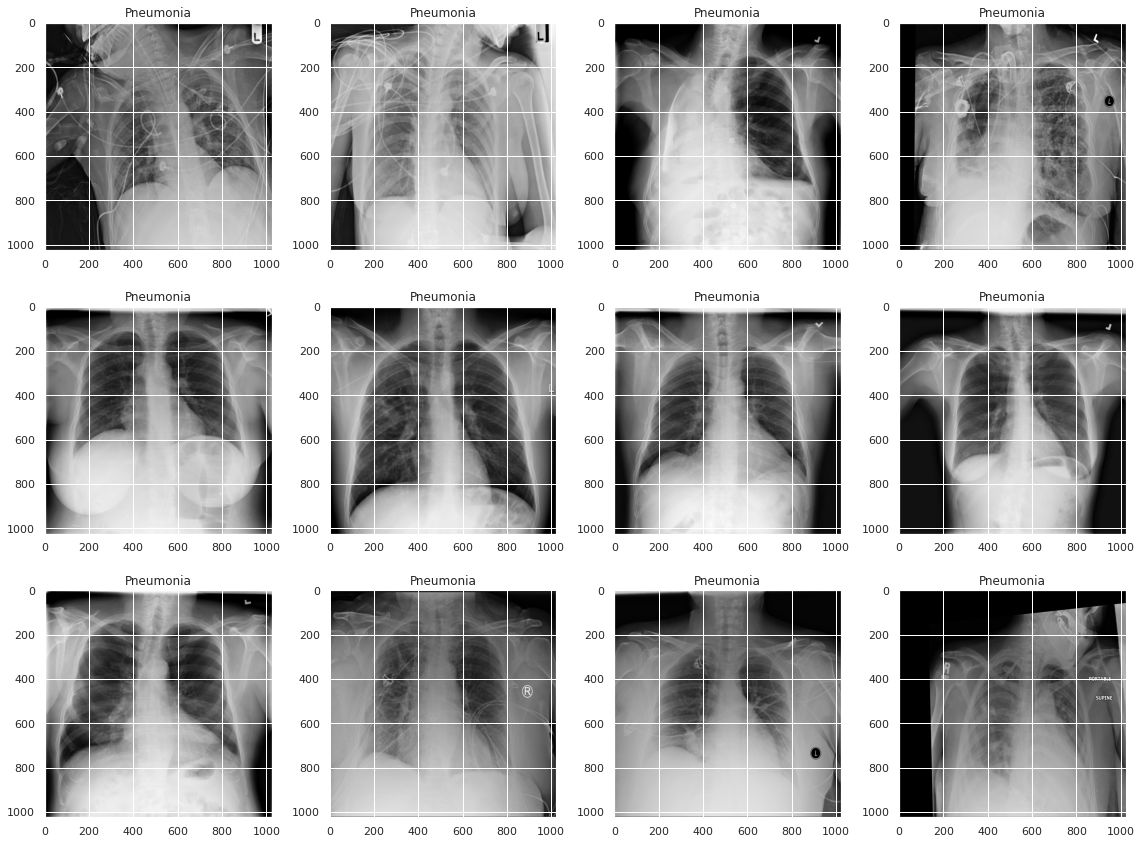

In [42]:
rows=3
cols=4

fig, m_axs = plt.subplots(rows,cols, figsize = (16, 12))
m_axs = m_axs.flatten()
imgs = sample_df_pneu.sample(rows*cols).img_path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(sample_df_pneu.iloc[ind]['Finding Labels'])
    ind=ind+1
    
plt.tight_layout()


In [43]:
sample_df_pneu['img_data'] = sample_df_pneu.apply(lambda x: io.imread(x['img_path']), axis=1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
bg_th = 0.1 


In [49]:
def show_image_mask(img_data, bg_th):
    mask = img_data > bg_th
    f = plt.figure(figsize = (16, 5))

    s1 = f.add_subplot(1, 3, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')

    s2 = f.add_subplot(1, 3, 2)
    s2.set_title('Mask')
    plt.imshow(mask.astype(int)*255, cmap='gray')
    
    s3 = f.add_subplot(1, 3, 3)
    s3.set_title('Intensity Distribution')
    get_dist_plot(img_data[mask])

    plt.show()

In [51]:
def get_dist_plot(df_col):
    ax = sns.distplot(df_col, rug=True)
    try:
        ax.set_xlim(0,df_col.max())
    except:
        None
    plt.show()

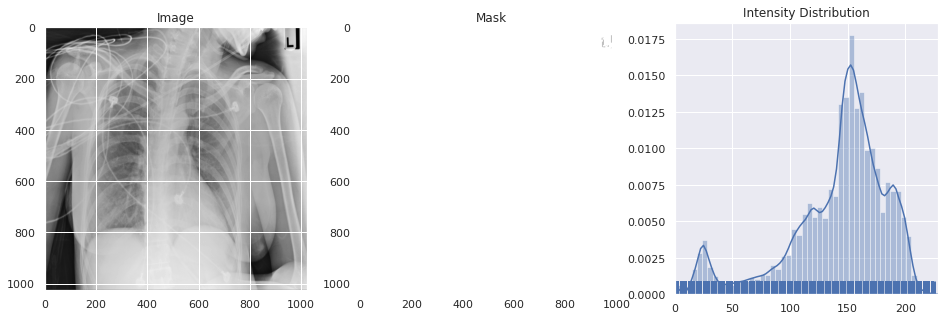

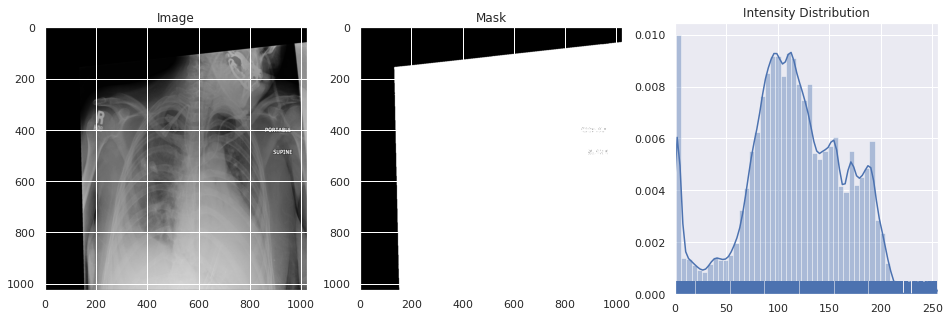

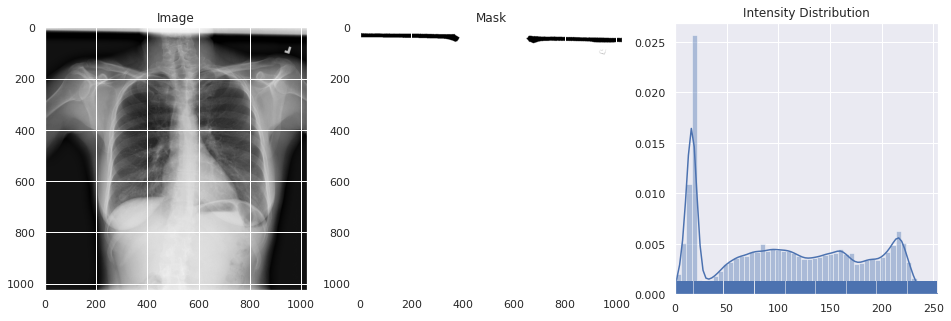

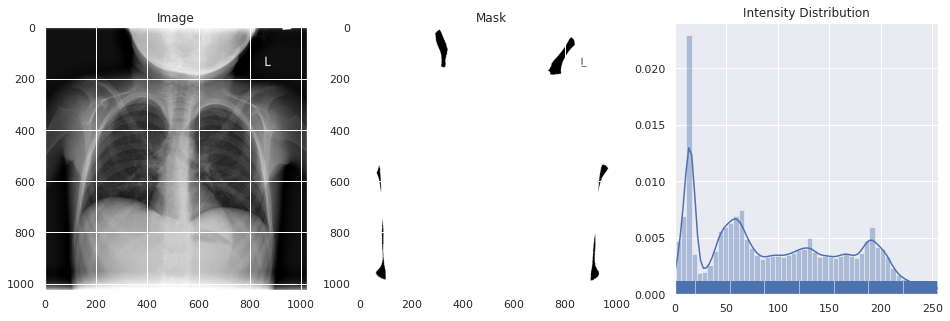

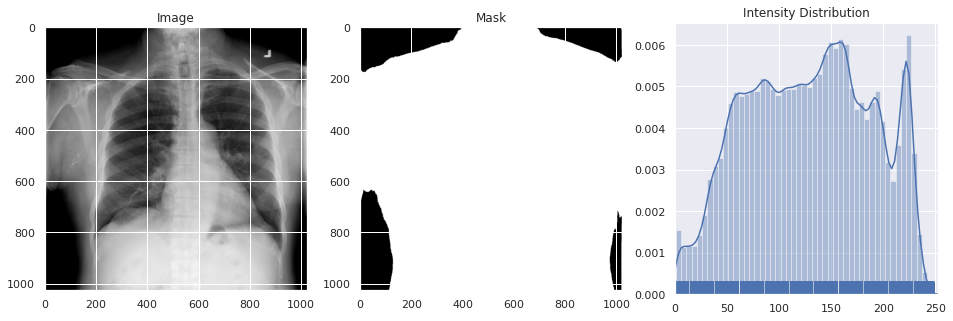

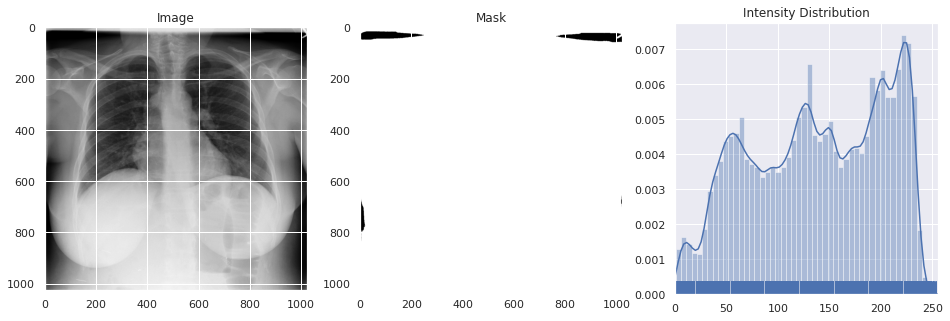

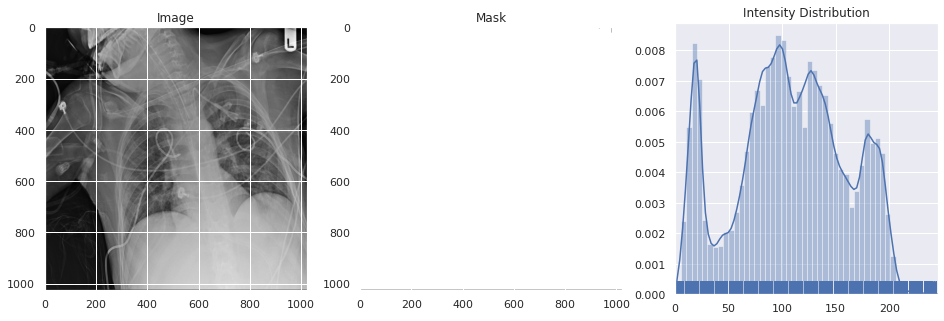

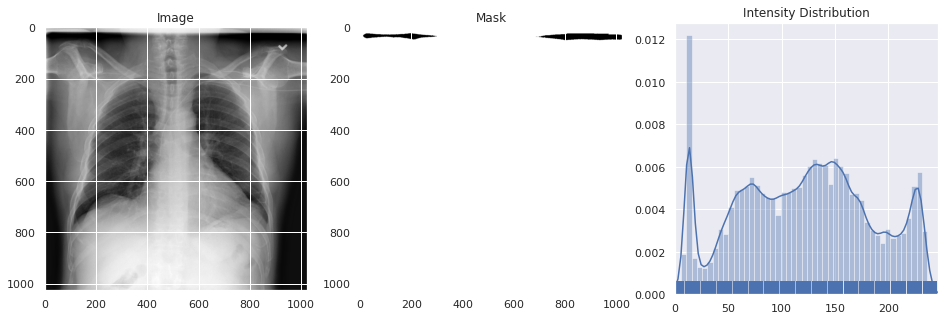

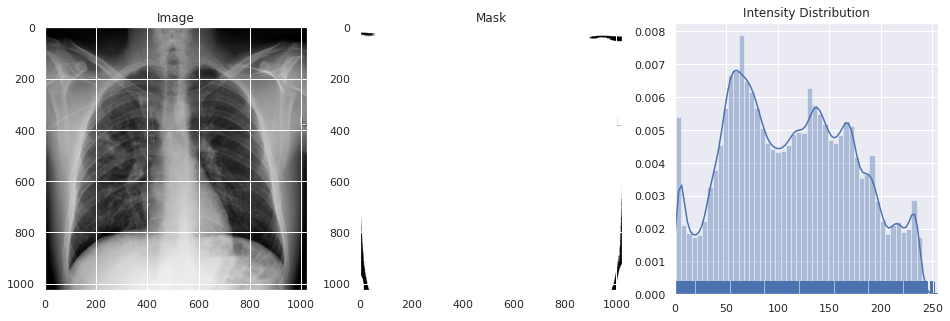

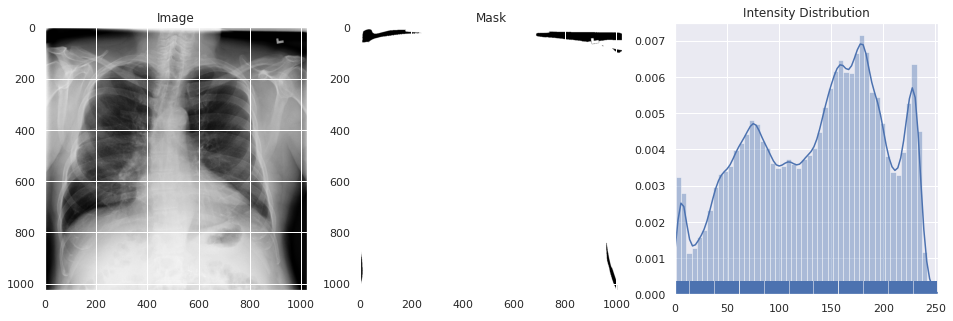

In [54]:
for img in sample_df_pneu.head(10).img_data.values:
    show_image_mask(img, bg_th)

In [61]:
def normalize_img(pixel_array):
    mean_intensity = np.mean(pixel_array)
    std_intensity = np.std(pixel_array)
    return (pixel_array.copy() - mean_intensity)/std_intensity

In [77]:
def get_intensities(label, bg_th):
    paths = list(sample_df[sample_df[label]==1]['img_path'].values)
    pneu_int = []
    for path in paths:
        img = normalize_img(io.imread(path))
        mask = img > bg_th
        pneu_int.extend(img[mask].flatten().tolist())
        return pneu_int

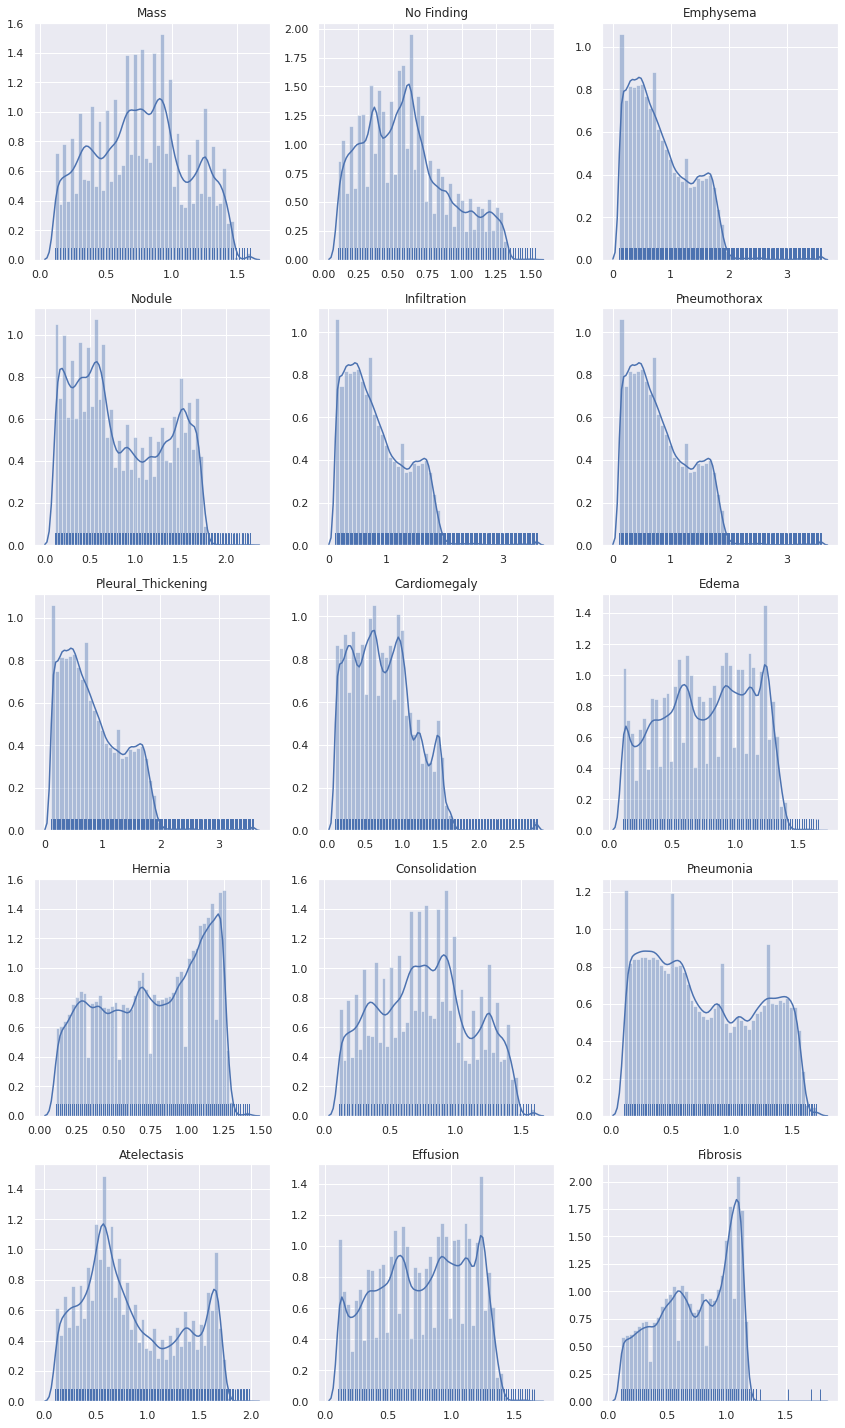

In [78]:
f = plt.figure(figsize=(12,20))
for i,finding in enumerate(labels):
    intensities = get_intensities(finding, bg_th)
    ax = f.add_subplot(5, 3, i+1)
    ax.set_title(finding)
    sns.distplot(intensities, rug=True)
plt.tight_layout()

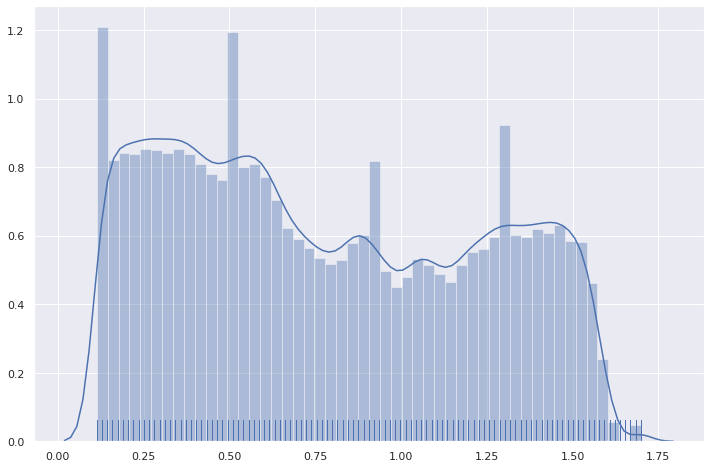

In [79]:
get_dist_plot(get_intensities('Pneumonia', bg_th))


Total unique labels: 15
